<a href="https://colab.research.google.com/github/k2moon/ml-hg/blob/main/hg_08_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망을 사용한 이미지 분류
---

## 핵심키워드
---
- Conv2D
- MaxPolling2D
- plot_model

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/8-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 패션 MNIST 데이터 불러오기
---
- 데이터 스케일링 : 0 ~ 255 => 0 ~ 1
- 완전 연결 신경망에서는 입력 이미지를 Dense층에 연결하기 위해 일렬로 펼쳤으나 합성곱 신경망은 2차원 그대로 사용
- 입력 데이터 흑백이미지는 채널이 없지만 2차원에 채널을 1을 추가한 3차원으로 reshape

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

# 3차원으로 reshape 및 스케일링
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


## 합성곱 신경망 만들기
---

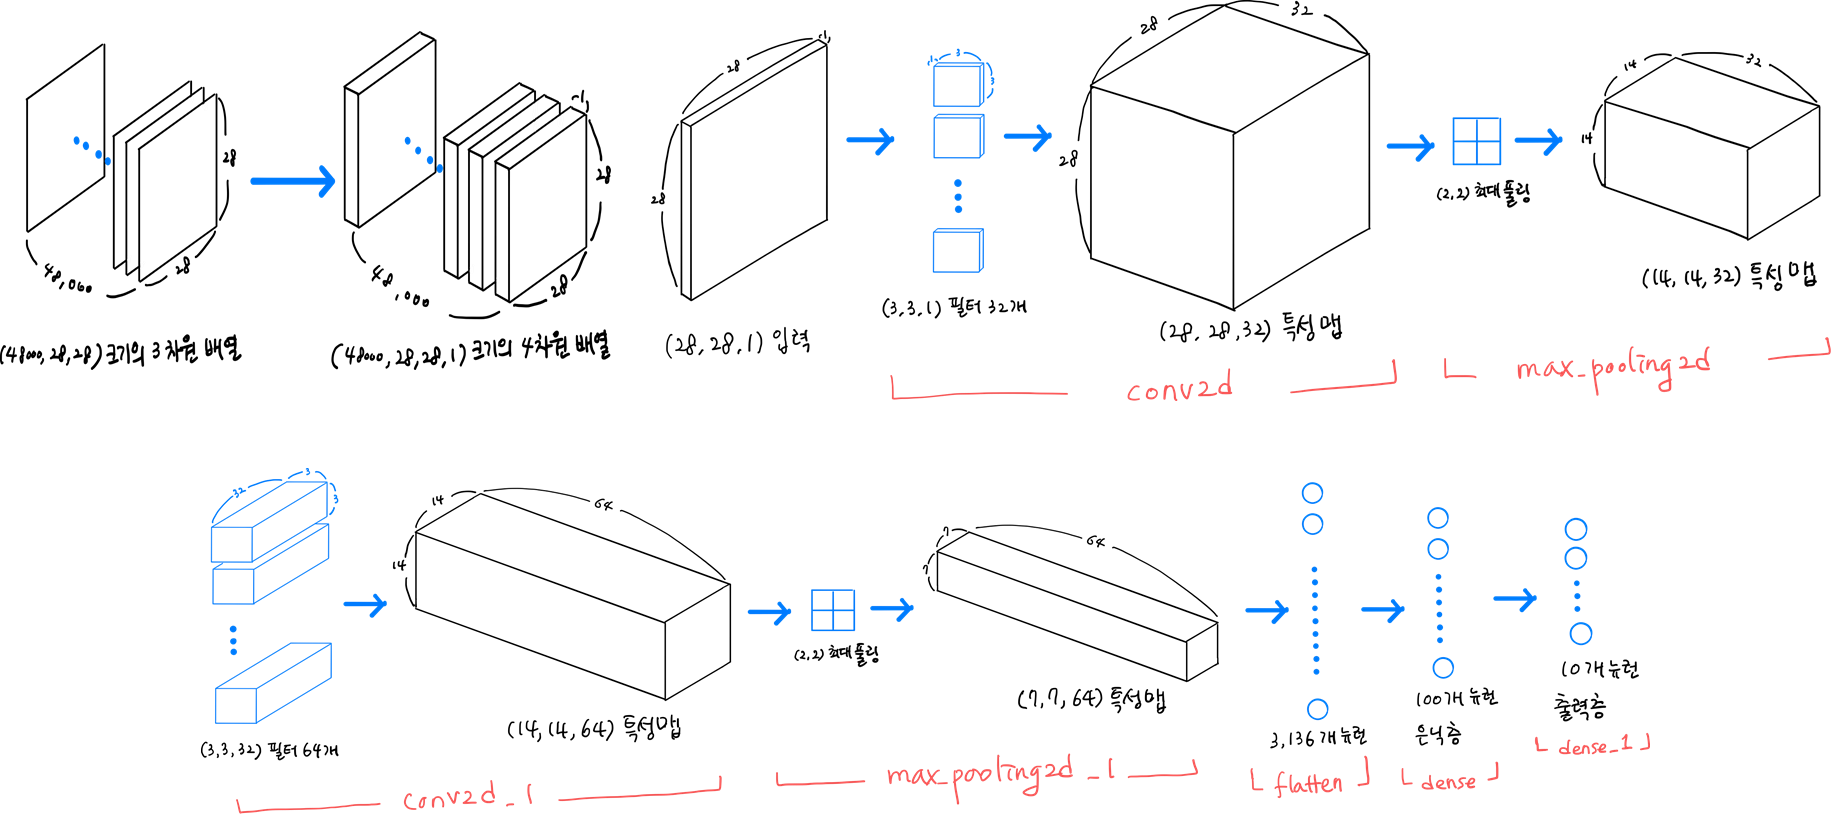

- keras.Sequential 클래스를 사용해 순서대로 구조 정의
- 1. keras.Sequential생성
- 2. keras.layers.Conv2D 합성곱 층 추가
 - 32개 필터, 커널 (3,3), input_shape에 3차원 값 
- 3. MaxPooling2D 플링 층 추가
 - (2,2) 플링 => 특성맵 크기 반으로 됨 (14,14,32)
- 4. keras.layers.Conv2D 두번째 합성곱 층 추가
 - 64개 필터, 세임패딩 사용
- 5. MaxPooling2D 두번째 플링 층 추가
 - (7,7,64)
- 6. Flatten 층 추가
- 7. Dense 은닉 층 추가
 - 100개 뉴런, relu 사용
- 8. Dropout 추가 
- 9. 출력 층 추가
 - 10분류, sotfmax 사용

In [3]:
model = keras.Sequential()

In [4]:
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                              padding='same', input_shape=(28,28,1)))

In [5]:
model.add(keras.layers.MaxPooling2D(2))

In [6]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [7]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

**층의 구성 그림 keras.utils.plot_model**

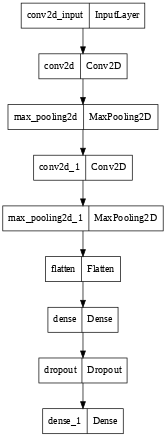

In [14]:
keras.utils.plot_model(model, dpi=50)

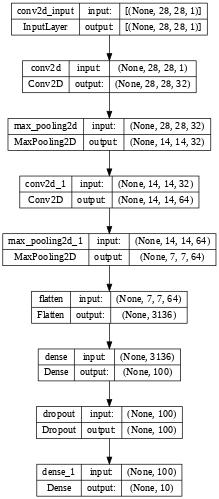

In [13]:
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi=50)

## 모델 컴파일과 훈련
---
- 1. 사전작업 compile(), 옵티마이저 지정 adam
- 2. ModelCheckpoint, EarlyStopping 콜백 최적의 모델값과 조기종료 지정
- 3. 훈련 
- 4. 손실 그래프 확인

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 16s 5ms/step - loss: 0.5396 - accuracy: 0.8062 - val_loss: 0.3296 - val_accuracy: 0.8788
Epoch 2/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3549 - accuracy: 0.8721 - val_loss: 0.2774 - val_accuracy: 0.8975
Epoch 3/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3031 - accuracy: 0.8884 - val_loss: 0.2621 - val_accuracy: 0.9029
Epoch 4/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2731 - accuracy: 0.9007 - val_loss: 0.2349 - val_accuracy: 0.9129
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2442 - accuracy: 0.9104 - val_loss: 0.2405 - val_accuracy: 0.9120
Epoch 6/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2274 - accuracy: 0.9172 - val_loss: 0.2222 - val_accuracy: 0.9188
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2108 - accuracy: 0.9236 - val_loss: 0.2163 - val_accuracy

> **90% 이상으로 정확도가 올라 갔음**

In [16]:
import matplotlib.pyplot as plt

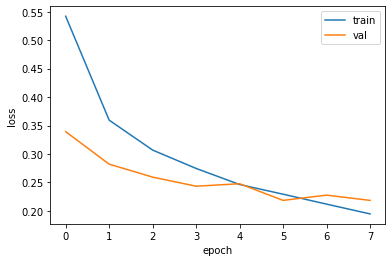

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [17]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.2163 - accuracy: 0.9210


[0.21628820896148682, 0.9210000038146973]

> **7에포크와 동일한 결과값**

### 실제 예측 해보기
---
- 첫번째 이미지를 실제 이미지로 대치

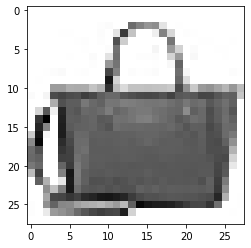

In [18]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

**예측 확률 확인**

In [19]:
# 차원을 맞추기 위해 슬라이싱 사용 (28,28,1) => (1,28,28,1)
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 129ms/step
[[4.7966600e-13 4.7645459e-24 7.6450404e-16 6.1063717e-17 1.9238344e-14
  3.6301439e-15 2.2403435e-15 3.9701342e-14 1.0000000e+00 4.3477812e-15]]


In [21]:
# 확률 최대값 index 찾기
import numpy as np
np.argmax(preds[0]) # 9번째 

8

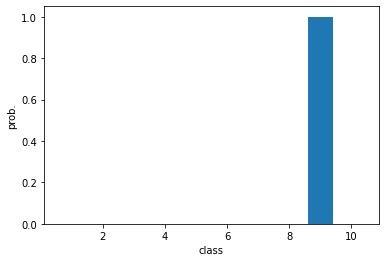

In [22]:
# 확률값 그래프로 확인
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [23]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [24]:
print(classes[np.argmax(preds)])

가방


### 테스트 세트  성능 측정
---

In [25]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [26]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 2s 4ms/step - loss: 0.2481 - accuracy: 0.9115


[0.2480708807706833, 0.9114999771118164]

- 과적합 없이 실전 투입시 약 91% 성능이 기대됨